<a href="https://colab.research.google.com/github/DutchVandaline/Artificial_Intelligence/blob/main/Vision_Transformer_self_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vision Transformer Paper Replicating

Making ViT architecture with PyTorch. Following is the paper **"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"**: https://arxiv.org/abs/2010.11929#

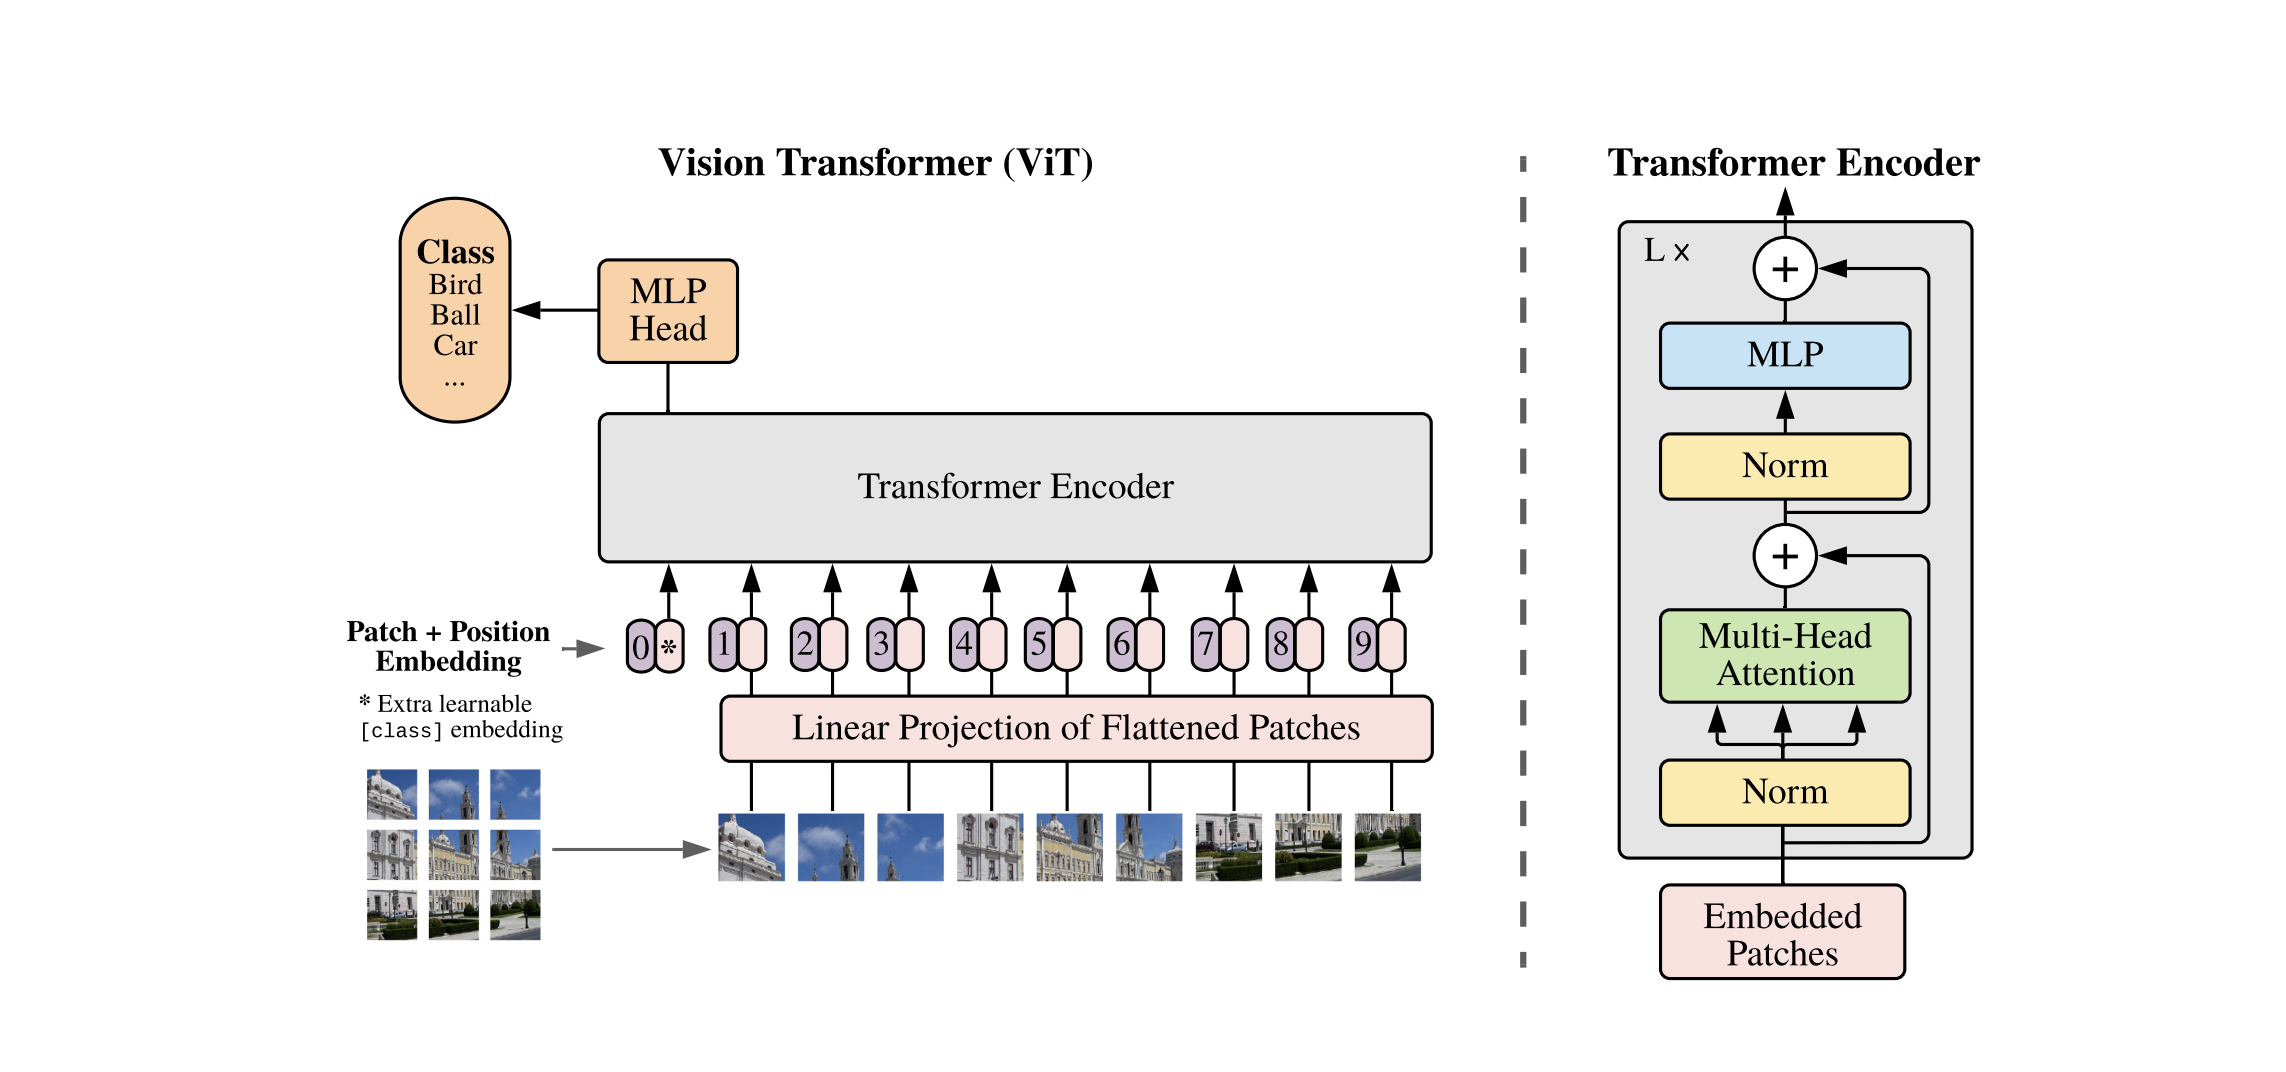

In [1]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt
print(f"torch version : {torch.__version__}")

torch version : 2.4.1+cu121


In [2]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/DutchVandaline/Artificial_Intelligence.git
    !mv Artificial_Intelligence/pytorch_modules .
    !mv Artificial_Intelligence/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'Artificial_Intelligence'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 189 (delta 65), reused 62 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (189/189), 13.41 MiB | 13.99 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
from torchvision import transforms
from pytorch_modules.pytorch_modules import data_setup

# Create image size
IMG_SIZE = 224  # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our small model)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

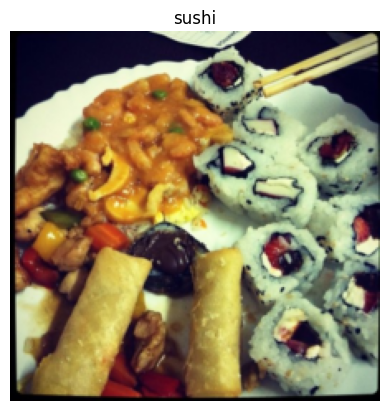

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## Exploring the Four Equations

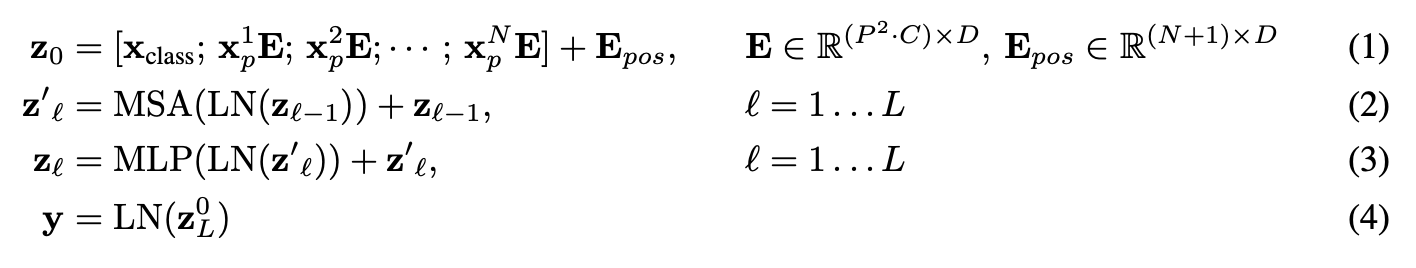

**Equation 1:** ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings... Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings...

```python
#In pseudocode:
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```


**Equation 2:** The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

```python
#In pseudocode:
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

**Equation 3:** Same as equation 2.

```python
#In pseudocode:
x_output_MLP_block = MLP_layer(LN_layer(x_input)) + x_output_MSA_block
```

**Equation 4:** Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)...

```python
#In pseudocode:
y = Linear_layer(LN_layer(x_output_MLP_block))
```

## Building Equation 1 in Pytorch

### Check Input and Output

> *An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D
sequence of token embeddings. To handle 2D images, we reshape the image x ∈ R
H×W×C into a
sequence of flattened 2D patches xp ∈ R
N×(P
2
·C)
, where (H, W) is the resolution of the original
image, C is the number of channels, (P, P) is the resolution of each image patch, and N = HW/P2
is the resulting number of patches, which also serves as the effective input sequence length for the
Transformer. The Transformer uses constant latent vector size D through all of its layers, so we
flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to
the output of this projection as the patch embeddings*

Input shape : $H \times{W} \times{C}$ <br>
Output shape : $N \times{(P^2 \dot C)}$ <br>
H : height of the original image <br>
N(resulting number of patches) : $H \times{W/P^2}$<br>
W : width of the original image <br>
C : number of channels <br>
P : resolution of each image patch <br>
D : constant vetor size D <br>

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate the number of patches N
number_of_patches = int((height*width)/ patch_size**2)
number_of_patches

196

In [11]:
# Calculate the input shape
embedding_layer_input_shape = (height, width, color_channels)

# Calculate the output shape
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

print(f"Input shape : {embedding_layer_input_shape}")
print(f"Output shape : {embedding_layer_output_shape} -> (number_of_patches, embedding_size)")

Input shape : (224, 224, 3)
Output shape : (196, 768) -> (number_of_patches, embedding_size)


(-0.5, 223.5, 223.5, -0.5)

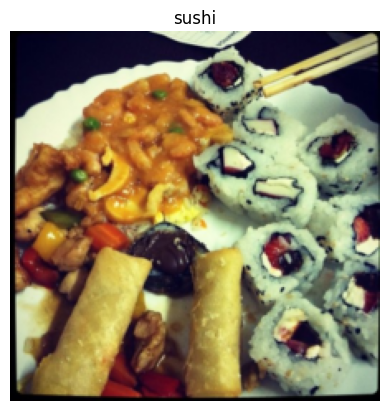

In [12]:
image_permuted = image.permute(1,2,0)

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size : 16 pixels x 16 pixels


Text(0.5, 0.98, 'sushi -> Patchified')

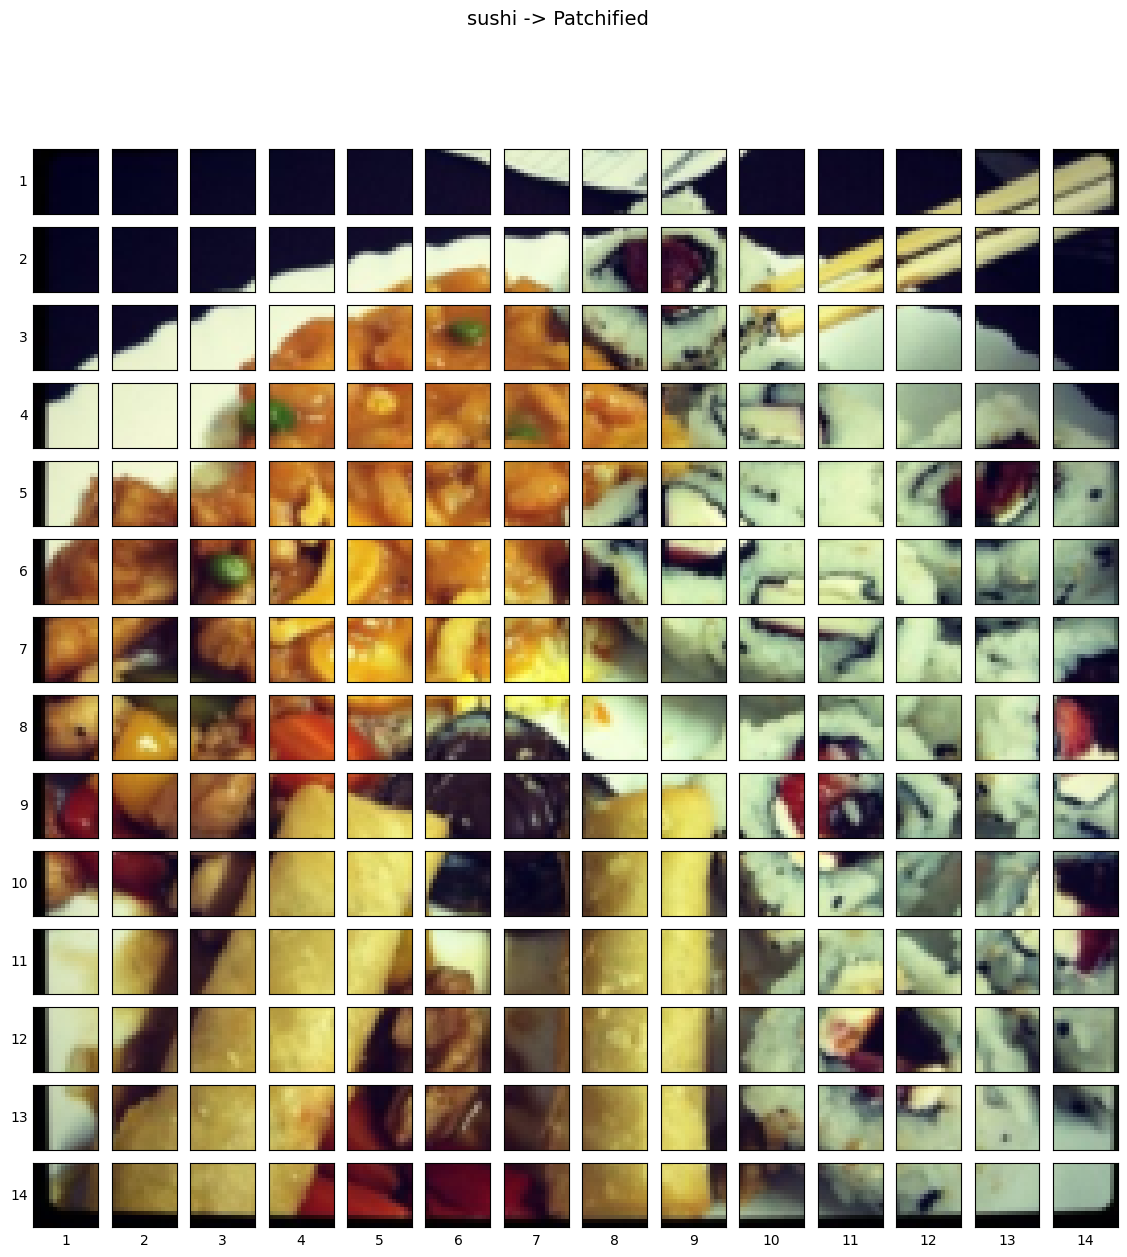

In [13]:
# Patchify the images
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches * num_patches}\
  \nPatch size : {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width: patch_width + patch_size, # iterate through width
                                    :])
    # Set up label information for each subplot (patch)
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

# set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)

### Patch Embedding

Patch Embedding : Use `conv2d` to make a patch Embedding. patch Embedding is for linear change to lower the dimension.

In [14]:
# Use conv2d to make a patch embeddings
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)


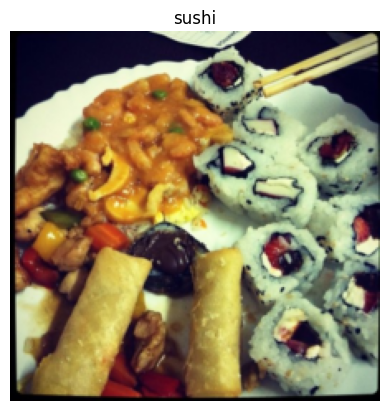

In [15]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [16]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color channel, )
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


>*the input sequence is obtained by simply
flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.*
Now we've passed a single image to our `conv2d` layer, it's shape if

```python
torch.Size([1,768,14,14]) # [batch_size embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [407, 717, 693, 8, 181]


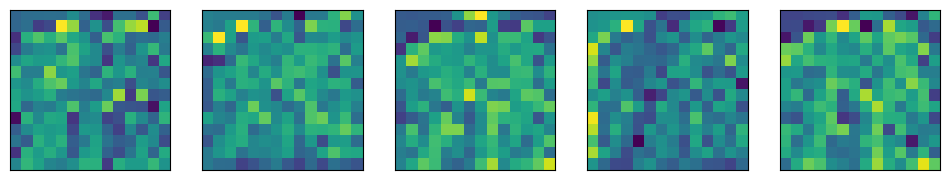

In [20]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0,758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension and remove from grad tracking/ switch to numpy
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [23]:
# Flattening embedding with `torch.nn.flatten`
# (batch_size, embedding_dim, feature_map_height, feature_map_width") -> (batch_size, number_of_batches, embedding_dim)
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

#### Moduling Patch Embedding

In [29]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)


  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patchsize, image shape : {image_resolution}, patch size: {self.patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0,2,1)

In [30]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image size : {image.unsqueeze(0).shape}")

patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape : {patch_embedded_image.shape}")

Input image size : torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape : torch.Size([1, 196, 768])


### Create the class token embedding

> *Similar to BERT’s [class] token, we prepend a learnable embedding to the sequence of embedded patches ($z^0_0$ = xclass), whose state at the output of the Transformer encoder ($z^0_L$) serves as theimage representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to z0L.*

<br>
Prepend a learnable class token to the start of the patch embedding.

In [31]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension=patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [32]:
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [33]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

print(patch_embedded_image_with_class_embedding)
print(patch_embedded_image_with_class_embedding.shape)

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-5.7291e-02, -8.7825e-03, -6.9066e-02,  ...,  2.7077e-02,
           1.9915e-02,  1.0614e-02],
         [-6.1664e-02, -2.6246e-04, -4.3854e-02,  ...,  4.8030e-02,
          -5.4146e-03,  2.6753e-03],
         ...,
         [-5.1426e-01,  1.5813e-01,  3.3813e-02,  ...,  2.4245e-01,
          -3.1692e-01,  5.8773e-02],
         [-6.1971e-01,  1.3668e-01,  7.5848e-02,  ...,  3.2162e-01,
          -2.1575e-01,  1.5112e-01],
         [-5.1490e-01, -1.2918e-01,  1.0141e-01,  ...,  1.9919e-01,
          -1.2740e-01,  8.8478e-02]]], grad_fn=<CatBackward0>)
torch.Size([1, 197, 768])


#### Create the position embedding

>*Position embeddings are added to the patch embeddings to retain positional information. We use
standard learnable 1D position embeddings, since we have not observed significant performance
gains from using more advanced 2D-aware position embeddings (Appendix D.4).*


$E ∈ R^{(P^2·C)×D}, Epos ∈ R^{(N+1)×D}$


In [34]:
number_of_patches = int((height * width) / patch_size **2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad = True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [35]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9427, 0.9912, 0.9309,  ..., 1.0271, 1.0199, 1.0106],
         [0.9383, 0.9997, 0.9561,  ..., 1.0480, 0.9946, 1.0027],
         ...,
         [0.4857, 1.1581, 1.0338,  ..., 1.2425, 0.6831, 1.0588],
         [0.3803, 1.1367, 1.0758,  ..., 1.3216, 0.7843, 1.1511],
         [0.4851, 0.8708, 1.1014,  ..., 1.1992, 0.8726, 1.0885]]],
       grad_fn=<AddBackward0>)